##05/10/2022 -- Universtiy of New England -- DSC 344: Machine Learning
###Rebecca Baert '23 -- Mushroom Classifer
This my final project for a machine learning class. The assignment was to chose a data set and apply techniques learned throughout the semester, provide justification of the steps we chose to take, and analysis of our results along the way. 

Data set I used: https://www.kaggle.com/datasets/uciml/mushroom-classification

In [ ]:
pip install fast_ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 787 kB/s 


In [7]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix
from fast_ml.model_development import train_valid_test_split
import lightgbm as lgb
from scipy.stats import randint
from sklearn.compose import ColumnTransformer
mush = pd.read_csv('sample_data/mushrooms1.csv')

# Viewing the data
To start we can view the first ten rows of data to get an idea of the structures. Based on these rows we can see:
* Class is the label (posionous or edibible). This is what we are going to try to predict. 
* There are 22 features, all of which are categorical. 

In [8]:
mush.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


## Checking for nans
First let's try this to see if there are any nan values is the entire data set.

In [ ]:
mush.isnull().values.any()

False

Supposedly there isn't, but lets check all the different values to make sure they aren't just being mistakes as a category. Additionally, we can look at the counts. This will give us the idea of the distribution of the features as well as look for outlier/mis-input data. 

In [9]:
for i in range(len(mush.columns)):
  print(mush.iloc[:,i].value_counts())

e    4208
p    3916
Name: class, dtype: int64
x    3656
f    3152
k     828
b     452
s      32
c       4
Name: cap-shape, dtype: int64
y    3244
s    2556
f    2320
g       4
Name: cap-surface, dtype: int64
n    2284
g    1840
e    1500
y    1072
w    1040
b     168
p     144
c      44
u      16
r      16
Name: cap-color, dtype: int64
f    4748
t    3376
Name: bruises, dtype: int64
n    3528
f    2160
y     576
s     576
a     400
l     400
p     256
c     192
m      36
Name: odor, dtype: int64
f    7914
a     210
Name: gill-attachment, dtype: int64
c    6812
w    1312
Name: gill-spacing, dtype: int64
b    5612
n    2512
Name: gill-size, dtype: int64
b    1728
p    1492
w    1202
n    1048
g     752
h     732
u     492
k     408
e      96
y      86
o      64
r      24
Name: gill-color, dtype: int64
t    4608
e    3516
Name: stalk-shape, dtype: int64
s    5176
k    2372
f     552
y      24
Name: stalk-surface-above-ring, dtype: int64
s    4936
k    2304
f     600
y     284
Name: stalk-

After looking at the value counts, we can see there are no missing values or outliers/mis-input data (these would have been shown by suspisiously low counts). 

## Data Visualization
Next we can look at some bar charts to get a better idea of the ditriubution of the data. 23 bar charts seemed like a lot so I only included four, one of the label (ebible or posionous) and three that I felt represented the distribution of the other features as well. These included gill attachment, stalk color above the ring, and habitat. 

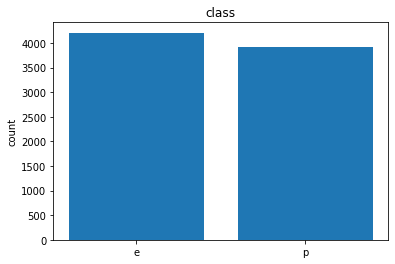

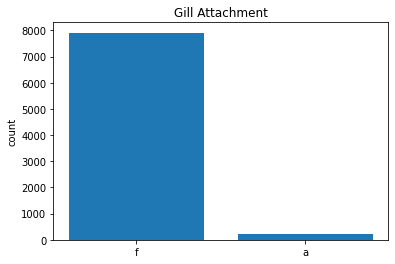

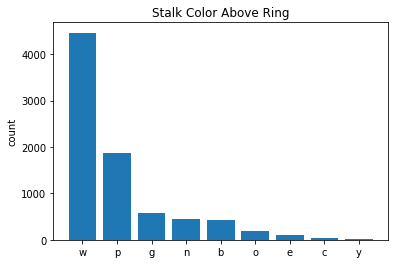

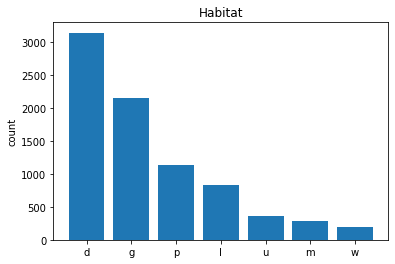

In [ ]:
A = mush['class'].value_counts().tolist()
Acats = ['e', 'p']
B = mush['gill-attachment'].value_counts().tolist()
Bcats = ['f','a']
C = mush['stalk-color-above-ring'].value_counts().tolist()
Ccats = ['w','p','g','n','b','o','e','c','y']
D = mush['habitat'].value_counts().tolist()
Dcats = ['d','g','p','l','u','m','w']

plt.bar(Acats,A)
plt.title('class')
plt.ylabel('count')
plt.show()

plt.bar(Bcats,B)
plt.title('Gill Attachment')
plt.ylabel('count')
plt.show()

plt.bar(Ccats,C)
plt.title('Stalk Color Above Ring')
plt.ylabel('count')
plt.show()

plt.bar(Dcats,D)
plt.title('Habitat')
plt.ylabel('count')
plt.show()

# Splitting the data
Now it's time to split the data. I decided to split into three groups, train, test, and validation, to ensure the hold out data didn't get touched until the very end. To do this three way split I used Fast Machine Learning's train, validation, test split because it was efficient. 

In [ ]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(mush, target = 'class', 
                                                                            train_size=0.8, valid_size=0.1, test_size=0.1)
y_train = y_train.tolist()
y_test = y_test.tolist()
y_valid = y_valid.tolist()

# One Hot Encoding
As I had all categorical data, and none of the Scikit Learn models support catagorical data, I had to one hot encode all of my features. So here I used one hot encoding to transform my X train and test set (saving the validation set for the pipeline at the end). 

### Why Not Ordinal Encoding?
As we learned, ordinal incoding implies order to the categories. So if I had used ordinal encoding my model would have associated categories 1 and 2 more closely than 1 and 4. These associations would have been reflected in decsion boundaries. For example a decision tree branching off depening on whether the feature is greater or less than 2. But I still implemented ordinal encoding for my X train and test. We will use it in a bit. 

In [ ]:
cat_encoder = OneHotEncoder(handle_unknown="ignore")
cat_encoder.fit(X_train)
X_train1hot = cat_encoder.transform(X_train)
X_test1hot = cat_encoder.transform(X_test)

In [ ]:
ord_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=20)
ord_encoder.fit(X_train)
X_train_ord = ord_encoder.transform(X_train)
X_test_ord = ord_encoder.transform(X_test)

# Training models
### Why decision trees?
This data set contained 23 species of mushrooms with 23 categorical features. From my understanding, non-poisonous mushrooms evolve to look like poisinous mushroom so they don't get eaten by predators. So likely, in this data set there are pairs of mushrooms with very similar features, but different class. It seemed unlikely to me a linear or polynomial would be successful in finding a boundary that splits the few features the pair differed in, for each of the pairs. It seemed more logical to me that a decision tree, making splits one feature at a time, would be more successful at weeding out these feaures. 

Moreover, we learned about several decision tree based ensemble methods throughout the class. I wanted to quickly run a few of them to see what worked best. I chose to use f1 score to evaluate the models as it has balance between precision and recall. I considered just using recall as my evaluation method, because its better to not eat an edible mushroom than to risk eating a poisonous one, but decided f1 gave a more balanced score. 

To start, I just wanted to run a few of these models using cross validations to get an intial idea of what worked best. For this inital test I chose regualarization parameters based on the 23 features. 

In [ ]:
tree_clf = DecisionTreeClassifier(max_depth=23)
tree_pred = cross_val_predict(tree_clf, X_train1hot, y_train, cv=8)
print(f1_score(y_train, tree_pred, pos_label="e"))

0.5026978417266187


In [ ]:

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=23,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_pred = cross_val_predict(bag_clf, X_train1hot, y_train, cv=8)
print(f1_score(y_train, bag_pred, pos_label="e"))

0.5424882962122287


In [ ]:

rnd_clf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=23, n_jobs=-1)
rnd_pred = cross_val_predict(rnd_clf, X_train1hot, y_train, cv=8)
print(f1_score(y_train, rnd_pred, pos_label="e"))

0.6154406409322651


Here I used tried the ensemble method, Light Gradient Boosting Classifier, which we did not cover in class. Similar to Scikit-Learn's gradient boosting tree, it works to sequntially adding predictors that correct the predecessor's residual error. Note: No parameter regularization was used for this model. 

In [ ]:
lgb_clf = lgb.LGBMClassifier()
lgb_pred = cross_val_predict(lgb_clf, X_train_ord, y_train, cv=8)
print(f1_score(y_train, lgb_pred, pos_label="e"))

1.0


# Evaluating the model so far
Besides the light graident boosting classifer, the random foreest model has the greatest f1 score, so we will move forward using it. 
### Confusion matrix
Based on the confusion matrix we can see the model is classifying all instances as edible, which from the bar chart above we can see is the more frequent class. Therefore the model is overfitting the data. 


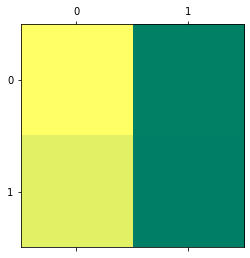

In [ ]:
conf_mx = confusion_matrix(y_train, rnd_pred)
plt.matshow(conf_mx, cmap=plt.cm.summer)
plt.show()

### ROC curve
A ROC curve plots the true positives compared to false positives. A good ROC curve would arch into the upper left hand corner (having a high true positive and low false positive count) and have an area under the curve of 1. The area under this ROC curve is .49, meaning the model is randomly guessing. 

### Overfitting 
Both the confusion matrix and ROC curve indicate the random forest model is overfitting the model, so we should lower the hyperparameters to regularize the model.


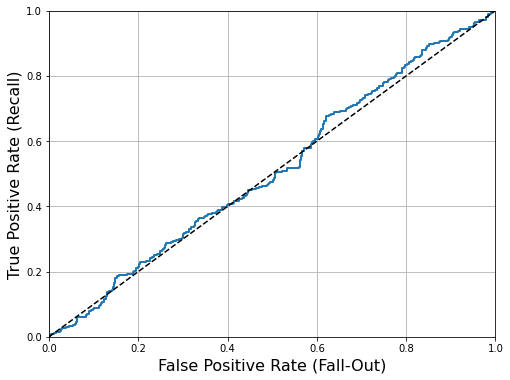

In [ ]:
rnd_clf.fit(X_train1hot, y_train)
rnd_pred_proba = rnd_clf.predict_proba(X_test1hot)
listprob = rnd_pred_proba[:,1]
fpr, tpr, thresholds = roc_curve(y_test, listprob, pos_label='e')
def plot_roc_curve(fpr, tpr, label=None): #plots roc curve
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)   
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                   
plot_roc_curve(fpr, tpr)                               
plt.show()

In [ ]:
roc_auc_score(y_test, listprob)

0.4909716983427834

# Randomized grid search
Despite the indications the model is overfitting the data, lowering the parameters of the random forest only lowered the f1 score further. I decided to run a randomized grid search to see if the best number of esimators and maximum leaves for the model. The resulting model found the best classifer had 445 estimators and 39 leaves.

In [ ]:
param_distribs = {
        'n_estimators': randint(low=10, high=500),
        'max_leaf_nodes': randint(low=1, high=50),
    }

forest_clf = RandomForestClassifier(random_state=42)
rnd_search = RandomizedSearchCV(forest_clf, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='f1', random_state=42)
rnd_search.fit(X_train1hot, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd7485aaf10>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd7489e1590>},
                   random_state=42, scoring='f1')

In [ ]:
rnd_search.best_estimator_

RandomForestClassifier(max_leaf_nodes=39, n_estimators=445, random_state=42)

In [ ]:
categorical_features = ["cap-shape", "cap-surface", "cap-color", "bruises", "odor", "gill-attachment", "gill-spacing", "gill-size", 
                        "gill-color", "stalk-shape", "stalk-root", "stalk-surface-above-ring", "stalk-surface-below-ring", 
                        "stalk-color-above-ring", "stalk-color-below-ring", "veil-type", "veil-color", "ring-number", 
                        "ring-type", "spore-print-color", "population", "habitat"]

preprocess = ColumnTransformer([
                                ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

In [ ]:
my_pipeline = Pipeline([
                        ("pre", preprocess),
                        ('rand', RandomForestClassifier(n_estimators=445, max_leaf_nodes=39, n_jobs=-1))
])

In [ ]:
my_pipeline.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cap-shape', 'cap-surface',
                                                   'cap-color', 'bruises',
                                                   'odor', 'gill-attachment',
                                                   'gill-spacing', 'gill-size',
                                                   'gill-color', 'stalk-shape',
                                                   'stalk-root',
                                                   'stalk-surface-above-ring',
                                                   'stalk-surface-below-ring',
                                                   'stalk-color-above-ring',
                                                   'stalk-color-below-ring',
                                                   'veil-typ

# Final model
I set up my pipeline using the best parameters found using the grid search and ran on the validation set. I got the final f1 score of 1... Which sounds too good to be true and it is.

### Why did I get an f1 score of 1?
Overfitting. With the high number of estimators and max leaves, the model overfit, finding a path for each species. Additionally, despite having around 8,000 instances, there were only 23 species. While some of the features may have varied within the same species, the number of these unique instances were likely limited. Meaning there were MANY repeat instances in the data set. The model preformed well on the validation set because despite keeping the model from training on the validation instances ahead of time, the model had actually already seen them in the training data because they were repeats. Therefore, the model overfit both the training and validation data, because the high regualarization parameters allowed the model to fit each unique instance.  



In [ ]:
y_pred=my_pipeline.predict(X_valid)
f1_score(y_valid, y_pred, pos_label="e")

1.0

Sources

https://towardsdatascience.com/how-to-split-data-into-three-sets-train-validation-and-test-and-why-e50d22d3e54c
https://www.tutorialspoint.com/how-to-plot-a-bar-chart-for-a-list-in-python-matplotlib

https://blog.dataiku.com/how-do-gradient-boosting-algorithms-handle-categorical-variables
https://datascience.stackexchange.com/questions/35713/i-got-100-accuracy-on-my-test-set-is-there-something-wrong
https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline.score_samples

